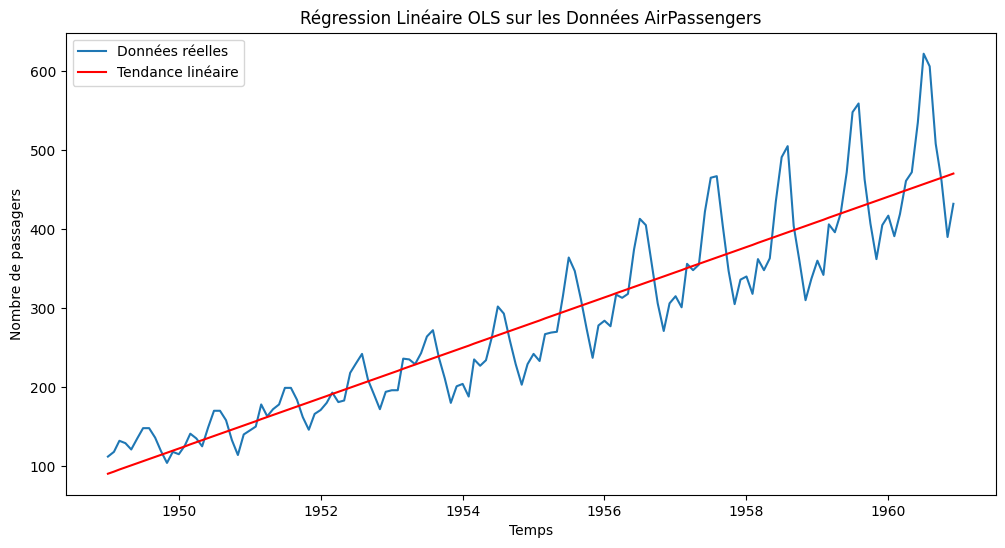

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     828.2
Date:                Thu, 31 Oct 2024   Prob (F-statistic):           4.02e-61
Time:                        02:06:24   Log-Likelihood:                -754.82
No. Observations:                 144   AIC:                             1514.
Df Residuals:                     142   BIC:                             1520.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         90.3100      7.636     11.826      0.0

C:\Users\syssa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\syssa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\syssa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\syssa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sy

ADF Statistic: -2.1019659058880045
p-value: 0.24372483602015327
Critique 1%: -3.4816817173418295
Critique 5%: -2.8840418343195267
Critique 10%: -2.578770059171598
Les données ne sont pas stationnaires. Application d'une différenciation supplémentaire.
ADF Statistic après différenciation: -2.829266824170008
p-value après différenciation: 0.05421329028382437


C:\Users\syssa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


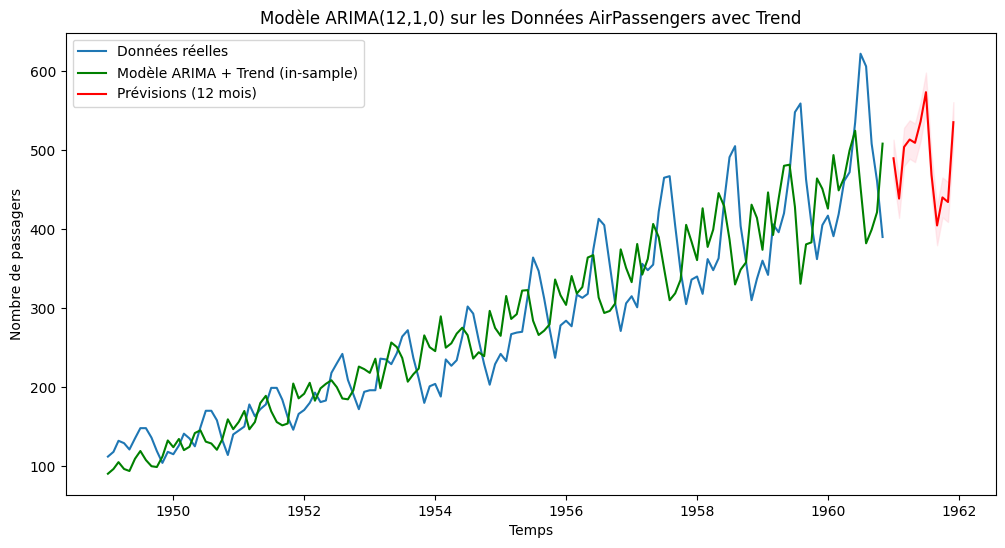

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  143
Model:                ARIMA(12, 1, 0)   Log Likelihood                -557.688
Date:                Thu, 31 Oct 2024   AIC                           1141.377
Time:                        02:06:28   BIC                           1179.803
Sample:                    02-01-1949   HQIC                          1156.991
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2519      0.091    -13.717      0.000      -1.431      -1.073
ar.L2         -1.3119      0.091    -14.362      0.000      -1.491      -1.133
ar.L3         -1.2654      0.095    -13.319      0.0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.datasets import get_rdataset
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller

# Charger les données
data = get_rdataset("AirPassengers").data

# Préparer les données
data['time'] = pd.date_range(start='1949-01-01', periods=len(data), freq='MS')
data.set_index('time', inplace=True)

# Variable dépendante (nombre de passagers)
y = data['value']

# Variable indépendante (temps)
X = np.arange(len(data)).reshape(-1, 1)  # Reshape pour créer une matrice colonne
X = sm.add_constant(X)  # Ajouter une constante pour le terme d'interception

# Appliquer la régression linéaire OLS
model = sm.OLS(y, X)
results = model.fit()

# Prédire les valeurs
data['trend'] = results.fittedvalues

# Tracer les résultats
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['value'], label='Données réelles')
plt.plot(data.index, data['trend'], label='Tendance linéaire', color='red')
plt.xlabel('Temps')
plt.ylabel('Nombre de passagers')
plt.title('Régression Linéaire OLS sur les Données AirPassengers')
plt.legend()
plt.show()

# Afficher le résumé des résultats
print(results.summary())

# Appliquer le modèle ARIMA
model = ARIMA(data['value'], order=(12, 1, 0))
data.index.freq = 'MS'  # Définir la fréquence à "début de mois"
results = model.fit()

# Déterminer la tendance par régression linéaire
time_index = np.arange(len(data)).reshape(-1, 1)
model_trend = LinearRegression().fit(time_index, data['value'])
trend = model_trend.predict(time_index)

# Enlever la tendance des données
data_detrended = data['value'] - trend

# Vérifier la stationnarité des données
result = adfuller(data_detrended.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critique {key}: {value}')

if result[1] > 0.05:
    print("Les données ne sont pas stationnaires. Application d'une différenciation supplémentaire.")
    data_detrended = data_detrended.diff().dropna()
    result = adfuller(data_detrended)
    print('ADF Statistic après différenciation:', result[0])
    print('p-value après différenciation:', result[1])

# Appliquer ARIMA(12,1,0) aux données dé-trendées
model_arima = ARIMA(data_detrended, order=(12, 1, 0))
results_arima = model_arima.fit()

# Ajuster les dimensions de 'trend' et 'results_arima.fittedvalues'
min_length = min(len(trend), len(results_arima.fittedvalues))
trend = trend[:min_length]
results_arima_fittedvalues = results_arima.fittedvalues[:min_length]

# Prédire les valeurs futures (12 mois) des résidus
forecast_arima = results_arima.get_forecast(steps=12)
forecast_values_arima = forecast_arima.predicted_mean
forecast_conf_int_arima = forecast_arima.conf_int()

# Prédire la tendance pour les 12 prochains mois
forecast_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
time_index_future = np.arange(len(data), len(data) + 12).reshape(-1, 1)
forecast_trend = model_trend.predict(time_index_future)

# Combiner les prédictions ARIMA avec la tendance
forecast_values = forecast_values_arima + forecast_trend

# Calculer la somme et la moyenne des prédictions
sum_forecast = forecast_values.sum()
mean_forecast = forecast_values.mean()

# Tracer les résultats in-sample et out-of-sample
plt.figure(figsize=(12, 6))
plt.plot(data.index[:min_length], data['value'][:min_length], label='Données réelles')
plt.plot(data.index[:min_length], trend + results_arima_fittedvalues, label='Modèle ARIMA + Trend (in-sample)', color='green')
plt.plot(forecast_index, forecast_values, label='Prévisions (12 mois)', color='red')
plt.fill_between(forecast_index,
                 forecast_conf_int_arima.iloc[:, 0] + forecast_trend,
                 forecast_conf_int_arima.iloc[:, 1] + forecast_trend,
                 color='pink', alpha=0.3)
plt.xlabel('Temps')
plt.ylabel('Nombre de passagers')
plt.title('Modèle ARIMA(12,1,0) sur les Données AirPassengers avec Trend')
plt.legend()
plt.show()

# Afficher le résumé des résultats ARIMA
print(results_arima.summary())

# Afficher la somme et la moyenne des prédictions
print(f"Somme des prédictions pour les 12 mois: {sum_forecast}")
print(f"Moyenne des prédictions pour les 12 mois: {mean_forecast}")